In [24]:
import numpy as np
import os
import copy
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix, kron
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.sparse import csr_matrix, csc_matrix, kron, identity
from scipy.sparse.linalg import expm

large = 40; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

In [25]:
# Define character sets
lowercase = 'abcdefghijklmnopqrstuvwxyz'
uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
special = '@#$%&'

# Combine all characters
all_chars = lowercase + uppercase + special

password = ''.join(np.random.choice(list(all_chars), size=20))
print(f"Generated password: {password}")

Generated password: RBLqmFdytgF%RUIbUc$f


In [26]:
I2 = csc_matrix(np.eye(2))
sigma_x = csc_matrix(np.array([[0, 1], [1, 0]]))
sigma_y = csc_matrix(np.array([[0, -1j], [1j, 0]]))
sigma_z = csc_matrix(np.array([[1, 0], [0, -1]]))
sigma_plus = (sigma_x + 1j * sigma_y).toarray() / 2
sigma_minus = (sigma_x - 1j * sigma_y).toarray() / 2

In [27]:
def vectorize_rho(rho):
     rho = rho.toarray()
     rho_vec = rho.flatten(order="F")
     return csc_matrix(rho_vec).T

def unvectorize_rho(rho_vec):
     rho = rho_vec.toarray().reshape((2, 2), order="F")
     return csc_matrix(rho)

gamma_1 = 0.6
gamma_2 = 0.5
Delta = 0.5

L = 1
J = 1
gamma_r = gamma_1
gamma_d = gamma_2

L_1 = sigma_minus
L_2 = (I2+sigma_z)/2

def L_int(x):
     return -1j * (kron(I2, J * L * x * sigma_x) - kron(J * L * x * sigma_x, I2))

def L_f():
     return -1j * (kron(I2, - Delta * sigma_z) - kron(- Delta * sigma_z, I2))

def L_rel():
     return gamma_1 * (kron(np.conjugate(L_1), L_1)
                        - 1/2 * kron(I2, np.conjugate(L_1).T @ L_1)
                        - 1/2 * kron((np.conjugate(L_1).T @ L_1).T, I2))
def L_dep():
     return gamma_2 * (kron(np.conjugate(L_2), L_2)
                        - 1/2 * kron(I2, np.conjugate(L_2).T @ L_2)
                        - 1/2 * kron((np.conjugate(L_2).T @ L_2).T, I2))

# Cost function construction

In [28]:
# Solution for steady-state variables x, y, z
def solution_set(Delta, J, L, gamma_d, gamma_r):
    # Common term in x and y
    sqrt_term = np.sqrt(gamma_r * (gamma_r + gamma_d) / (8 * J * L * Delta))
    
    # Correction term for x and y
    correction_term = 1 - (16 * Delta**2 + (gamma_r + gamma_d)**2) / (16 * J * L * Delta)
    
    # x coordinate calculation (positive and negative solutions)
    x_pos = (4 * Delta / (gamma_r + gamma_d)) * sqrt_term * np.sqrt(correction_term)
    x_neg = -x_pos

    # y coordinate calculation (positive and negative solutions)
    y_pos = sqrt_term * np.sqrt(correction_term)
    y_neg = -y_pos

    # z coordinate calculation
    z = (-16 * Delta**2 - (gamma_r + gamma_d)**2) / (16 * J * L * Delta)

    # Returning two sets of solutions
    return [(x_pos, y_pos, z), (x_neg, y_neg, z)]

In [29]:
def build_mean_field_hamiltonian(x_mean, J, L, Delta):
    """Hamiltonian in the mean field limit."""
    return J * L * x_mean * sigma_x - Delta * sigma_z

def jump_operators(gamma_r, gamma_d):
    """Lindblad operator acting on a single qubit."""
    L1 = np.sqrt(gamma_r) * (sigma_x - 1j * sigma_y) / 2
    L2 = np.sqrt(gamma_d) * (I2 + sigma_z) / 2
    return L1, L2

def lindbladian(rho, x_mean, J, L, Delta, gamma_r, gamma_d):
    """Construct the Lindblad equation."""
    H = build_mean_field_hamiltonian(x_mean, J, L, Delta)
    L1, L2 = jump_operators(gamma_r, gamma_d)

    # Commutator part: -i [H, rho]
    comm = -1j * (H @ rho - rho @ H)

    # Dissipators:
    dis1 = L1 @ rho @ L1.conj().T - 0.5 * (L1.conj().T @ L1 @ rho + rho @ L1.conj().T @ L1)
    dis2 = L2 @ rho @ L2.conj().T - 0.5 * (L2.conj().T @ L2 @ rho + rho @ L2.conj().T @ L2)

    return comm + dis1 + dis2

def cost_function(rho, x_mean, J, L, Delta, gamma_r, gamma_d):
    """
    Cost = Tr[ (L rho)^† (L rho) ], where L is the Lindbladian superoperator.
    Here, L_rho is the matrix returned by lindbladian(rho, x_mean).
    """
    rho = csr_matrix(rho)
    L_rho = lindbladian(rho, x_mean, J, L, Delta, gamma_r, gamma_d)
    return np.real(L_rho.getH().dot(L_rho).diagonal().sum())

In [30]:
def variational_ansatz(number_of_layers, angles_lst, x, rho_i):
    rho = rho_i
    for i in range(number_of_layers):
        theta_int, theta_f, theta_rel, theta_dep = angles_lst[i]
        rho = expm(theta_int * L_int(x)) @ rho
        rho = expm(theta_f * L_f())     @ rho
        rho = expm(theta_rel * L_rel())   @ rho
        rho = expm(theta_dep * L_dep())   @ rho
    return rho

# Quantum circuit

In [31]:
# # Variational ansatz.
# import qiskit
# from qiskit import QuantumCircuit
# from qiskit.quantum_info import DensityMatrix, partial_trace
# from qiskit.quantum_info import SparsePauliOp
# from qiskit.circuit.library import PauliEvolutionGate

# from qiskit_aer import AerSimulator
# from qiskit_aer.primitives import SamplerV2 as Sampler
# #from qiskit_ibm_runtime import SamplerV2 as Sampler
# # from qiskit.primitives import StatevectorSampler
# # sampler = StatevectorSampler()
# sampler = Sampler()
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [32]:
# def ansatz_circuit(angles_lst, num_layer, num_qubit):

#      qc = QuantumCircuit(num_qubit)
#      for qubit in range(num_qubit):
#           qc.h(qubit)

#      for layer in range(num_layer):
#           for qubit in range(1,num_qubit):
#                theta_1 = angles_lst[layer][0]
#                theta_2 = angles_lst[layer][1]               
#                theta_r = angles_lst[layer][2]
#                theta_d = angles_lst[layer][3]
#                qc.rx(theta_1,qubit)
#                qc.rz(theta_2,qubit)

#                qc.cry(theta_r, qubit, 0)
#                qc.cx(0, qubit)

#                qc.reset(0)

#                qc.cry(theta_d, qubit, 0)

#                qc.reset(0)  

#      return qc

# number_of_layers = 1
# initial_thetas = [[0.1, 0.1, 0.1, 0.2] for _ in range(number_of_layers)]

# x = 1.5
# dt = 0.2
# ansatz_circuit(initial_thetas, num_layer=number_of_layers, num_qubit=2).draw('mpl', scale = 2)#.savefig('variational_circuit.pdf', dpi=600, bbox_inches='tight')

In [33]:
# # [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# # https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

# from qiskit_aer import AerSimulator
# from qiskit import transpile

# from qiskit_aer.primitives import SamplerV2 as Sampler
# #from qiskit_ibm_runtime import SamplerV2 as Sampler
# # from qiskit.primitives import StatevectorSampler
# # sampler = StatevectorSampler()
# sampler = Sampler()


# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# # YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# # QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# # service = QiskitRuntimeService()
# # backend = service.backend("ibm_brisbane")
# # noise_model = NoiseModel.from_backend(backend)

# def return_density_matrix(quantum_circuit):

#      quantum_circuit.save_density_matrix()  # Save the density matrix

#      # Step 2: Simulate the circuit
#      simulator = AerSimulator()  # Aer simulator supports reset gates
#      quantum_circuit = transpile(quantum_circuit, simulator)
#      result = simulator.run(quantum_circuit).result()
#      # Step 3: Extract the density matrix
#      rho_full = DensityMatrix(result.data()["density_matrix"])

#      # Step 4: Compute the reduced density matrix for the second qubit
#      rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
#      rho_1_matrix = rho_1.data

#      return rho_1_matrix

# def update_angles(x, current_angles_lst, number_of_layers, learning_rate):
#     """
#     Perform parameter-shift updates on angles for a VQA circuit.
    
#     Parameters:
#         current_angles_lst (list of lists): Current angles for each layer (shape: [number_of_layers, 8]).
#         number_of_layers (int): Number of layers in the VQA circuit.
#         learning_rate (float): Learning rate for gradient descent.

#     Returns:
#         updated_angles (list of lists): Updated angles after applying parameter-shift rule.
#     """
#     # Initialize the updated angles as a copy of the current angles
#     updated_angles = np.array(current_angles_lst, copy=True)
    
#     # Iterate over each layer and each parameter
#     for i in range(number_of_layers):
#         for j in range(4):
#             # Create shifted angle sets for parameter (i, j)
#             angles_plus = np.array(current_angles_lst, copy=True)
#             angles_minus = np.array(current_angles_lst, copy=True)
            
#             # Shift the specific parameter
#             angles_plus[i][j] += np.pi / 2
#             angles_minus[i][j] -= np.pi / 2
            
#             # Compute the cost for shifted parameters
#             # ansatz_circuit(angles_lst, x, dt, number_of_layers, num_qubit=2)
#             cost_plus = cost_function(return_density_matrix(ansatz_circuit(angles_plus, number_of_layers, num_qubit=2)), x, J, L, Delta, gamma_r, gamma_d)
#             cost_minus = cost_function(return_density_matrix(ansatz_circuit(angles_minus, number_of_layers, num_qubit=2)), x, J, L, Delta, gamma_r, gamma_d)
            
#             # Compute the gradient for this parameter
#             gradient = (cost_plus - cost_minus) / 2
            
#             # Update the parameter using gradient descent
#             updated_angles[i][j] -= learning_rate * gradient
    
#     return updated_angles

# Optimization

In [34]:
# # Parameters
# initial_learning_rate = 0.1
# number_of_layers = 1
# max_iterations = 20
# tolerance_for_convergence = 1e-2

# initial_angles_lst = [[1.5, -0.5, 2.5, 1.5] for _ in range(number_of_layers)]
# angles_lst = initial_angles_lst.copy()
# best_angles_lst = initial_angles_lst.copy()

# # Initialize optimization variables
# number_of_iteration = 0
# best_cost = float("inf")
# best_iteration = 0
# cost_function_values_lst = []

# # Initial value of x from the density matrix
# rho_i = np.array([[1, 1], [1, 1]]) / 2
# x = np.real(np.trace(rho_i @ sigma_x))
# rho_lst = [rho_i]

# x_values_lst = [x**2]

# # Print initial state
# print("Initial angles: ", initial_angles_lst)

# # Optimization loop
# while number_of_iteration < max_iterations:
    
#     # Generate variational circuit and compute cost
#     vqa_circuit = ansatz_circuit(angles_lst, number_of_layers, num_qubit=2)
#     rho = return_density_matrix(vqa_circuit)
#     rho_lst.append(rho)
#     cost_value =  cost_function(rho, x, J, L, Delta, gamma_r, gamma_d)

#     # Value of x from the density matrix
#     x = np.real(np.trace(rho @ sigma_x))
#     x_values_lst.append(x**2)

#     # Record and display the cost
#     cost_function_values_lst.append(cost_value)
#     print(f"Iteration {number_of_iteration}: Cost value = {cost_value:.10f}")

#     # Update best solution
#     if cost_value < best_cost:
#         best_cost = cost_value
#         best_angles_lst = angles_lst.copy()
#         best_iteration = number_of_iteration

#     # Check for convergence
#     if cost_value < tolerance_for_convergence:
#         print("Optimization has converged.")
#         print(f"Best cost value: {best_cost:.10f}")
#         print("Best angles:", best_angles_lst)
#         break

#     # Adjust learning rate
#     learning_rate = initial_learning_rate / (0.1*number_of_iteration + 1)

#     # Update angles using the parameter-shift rule
#     angles_lst = update_angles(x, angles_lst, number_of_layers, learning_rate)

#     # Increment iteration counter
#     number_of_iteration += 1

# # Post-optimization summary
# if number_of_iteration == max_iterations:
#     print("The optimization did not converge within the maximum iterations.")
# print(f"Best cost value: {best_cost:.10f}")
# print("Best angles:", best_angles_lst)
# print('Variational solution: x = ', np.real(np.trace(rho_lst[best_iteration] @ sigma_x)), 
#     'y = ', np.real(np.trace(rho_lst[best_iteration] @ sigma_y)), 
#     'z = ', np.real(np.trace(rho_lst[best_iteration] @ sigma_z)))
# print('Exact solution:', solution_set(Delta, J, L, gamma_d, gamma_r)[0])

In [35]:
# x_steady_state, y_steady_state, z_steady_state = solution_set(Delta, J, L, gamma_d, gamma_r)[0]
# # Plotting the cost function vs iterations with publication-quality settings.
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(cost_function_values_lst, marker='o', linestyle='-', color='blue', markersize=10, linewidth=2, label='Cost Function')
# print('Best cost: ', cost_function_values_lst[-1])
# ax.plot(np.array(x_values_lst)**2, marker='h', linestyle='-', color='red', markersize=10, linewidth=2, label=r'$x(t)^{2}$')
# plt.axhline(y=0, color='blue', linestyle='--', linewidth=1)
# plt.axhline(y=x_steady_state**2, color='red', linestyle='--', linewidth=1, label=r'Exact $M_{MF}$')
# ax.set_xlabel('Iteration', labelpad=20)
# ax.set_ylabel('Cost', labelpad=20)
# ax.legend()
# plt.tight_layout()
# for spine in ax.spines.values():
#      spine.set_linewidth(2)
# ax.tick_params(axis='both', which='major', length=10)
# plt.show()

# General gradient descent algorithm for optimization

In [36]:
def gradient_descent_optimizer(rho_initial, number_of_layers, angles_lst, learning_rate, max_iterations, tolerance=1e-6, delta=0.1):
    rho_vec = rho_initial
    rho_vec_lst = [rho_initial]

    x_val = np.real((sigma_x @ unvectorize_rho(rho_initial)).diagonal().sum())
    cost_function_value = cost_function(unvectorize_rho(rho_vec), x_val, J, L, Delta, gamma_1, gamma_2)
    cost_function_lst = [cost_function_value]
    x_values_lst = [x_val]
    best_angles_lst = [list(a) for a in angles_lst]
    best_cost = float('inf')

    for iteration in range(max_iterations):
        current_learning_rate = learning_rate # / (1 + iteration)
        print(f"Iteration {iteration}: Learning rate = {current_learning_rate:.10f}")

        if cost_function_value < best_cost:
            best_cost = cost_function_value
            best_angles_lst = [list(a) for a in angles_lst]

        if iteration > 0 and abs(cost_function_lst[-1] - cost_function_lst[-2]) < tolerance:
            break

        gradients = [[0.0 for _ in range(4)] for _ in range(number_of_layers)]

        # Get current state before gradient updates
        rho_vec = variational_ansatz(number_of_layers, angles_lst, x_val, vectorize_rho(rho_initial))
        x_val = np.real((sigma_x @ unvectorize_rho(rho_vec)).diagonal().sum())
        rho_vec_lst.append(rho_vec)
        x_values_lst.append(x_val)

        for layer in range(number_of_layers):
            for p in range(4):
                angles_copy = [list(a) for a in angles_lst]
                theta_p = angles_copy[layer][p]

                if p == 0:
                    theta_2 = angles_copy[layer][1]
                    theta_r = angles_copy[layer][2]
                    theta_d = angles_copy[layer][3]
                    y = np.real((sigma_y @ unvectorize_rho(rho_vec)).diagonal().sum())
                    z = np.real((sigma_z @ unvectorize_rho(rho_vec)).diagonal().sum())

                    # Derivative as shown in formula: -J x (yZ + zX)
                    G_op = y * sigma_z + z * sigma_x
                    drho_dtheta_1 = - J * x_val * G_op

                    # Apply remaining layers
                    drho_dtheta_1 = expm(theta_2 * L_f()) @ vectorize_rho(drho_dtheta_1)
                    drho_dtheta_1 = expm(theta_r * L_rel()) @ drho_dtheta_1
                    drho_dtheta_1 = expm(theta_d * L_dep()) @ drho_dtheta_1

                    # Compute gradient
                    Lrho = lindbladian(unvectorize_rho(rho_vec), x_val, J, L, Delta, gamma_1, gamma_2)
                    Ld_rho = lindbladian(unvectorize_rho(drho_dtheta_1), x_val, J, L, Delta, gamma_1, gamma_2)
                    gradients[layer][0] = 2 * np.real((Lrho.getH().dot(Ld_rho)).diagonal().sum())

                else:
                    Liouvillians = [L_int(x_val), L_f(), L_rel(), L_dep()]
                    exp_list = []
                    for i in range(4):
                        angle = angles_copy[layer][i]
                        Li = Liouvillians[i]
                        exp_list.append(expm(angle * Li))

                    U_leq = identity(exp_list[0].shape[0], format='csc')
                    for i in range(p + 1):
                        U_leq = exp_list[i] @ U_leq

                    U_gt = identity(exp_list[0].shape[0], format='csc')
                    for i in range(3, p, -1):
                        U_gt = exp_list[i] @ U_gt

                    drho_dtheta = U_gt @ (Liouvillians[p] @ (U_leq @ vectorize_rho(rho_initial)).toarray())

                    rho_current = unvectorize_rho(rho_vec)
                    drho_unvec = unvectorize_rho(csc_matrix(drho_dtheta))
                    Lrho = lindbladian(rho_current, x_val, J, L, Delta, gamma_1, gamma_2)
                    Ld_rho = lindbladian(drho_unvec, x_val, J, L, Delta, gamma_1, gamma_2)
                    gradients[layer][p] = 2 * np.real((Lrho.getH().dot(Ld_rho)).diagonal().sum())

        for layer in range(number_of_layers):
            for p in range(4):
                angles_lst[layer][p] -= current_learning_rate * gradients[layer][p]

        # Evaluate the final density matrix after angle update
        rho_final = variational_ansatz(number_of_layers, angles_lst, x_val, vectorize_rho(rho_initial))
        cost_function_value = np.real(cost_function(unvectorize_rho(rho_final), x_val, J, L, Delta, gamma_1, gamma_2))
        cost_function_lst.append(cost_function_value)
        print(f"Iteration {iteration}: Cost function value = {cost_function_value:.10f}")
        print(f"Current angles: {angles_lst}")

    return best_angles_lst, best_cost, x_values_lst, rho_vec_lst, cost_function_lst

In [39]:
x_steady_state, y_steady_state, z_steady_state = solution_set(Delta, J, L, gamma_d, gamma_r)[0]

number_of_layers = 1
initial_thetas = [[0.1, 0.1, 0.3, 0.2] for _ in range(number_of_layers)]
print('Initial angles: ', initial_thetas)
rho_i = vectorize_rho( csr_matrix( I2 + sigma_y + sigma_x) / 2)

best_angles, best_cost, x_values, rho_values, cost_values = gradient_descent_optimizer(
    rho_i, number_of_layers, initial_thetas, learning_rate=0.1, max_iterations=50
)
print('Best angles: ', best_angles)

Initial angles:  [[0.1, 0.1, 0.3, 0.2]]
Iteration 0: Learning rate = 0.1000000000
Iteration 0: Cost function value = 1.1448451277
Current angles: [[np.float64(0.3535647927648412), np.float64(0.25237371194927505), np.float64(0.5197878992769074), np.float64(0.27899730642099246)]]
Iteration 1: Learning rate = 0.1000000000
Iteration 1: Cost function value = 0.8332936946
Current angles: [[np.float64(0.54232548706711), np.float64(0.2620564611427984), np.float64(0.768535142507901), np.float64(0.3234514583251247)]]
Iteration 2: Learning rate = 0.1000000000
Iteration 2: Cost function value = 0.4984144615
Current angles: [[np.float64(0.6093103417504206), np.float64(0.20703310228852356), np.float64(0.9425910878719759), np.float64(0.3491419182205471)]]
Iteration 3: Learning rate = 0.1000000000
Iteration 3: Cost function value = 0.3528013717
Current angles: [[np.float64(0.645350082023294), np.float64(0.17291692927538216), np.float64(1.0631401913291338), np.float64(0.36851783181475783)]]
Iteration 4

Best cost:  0.009274447327678823


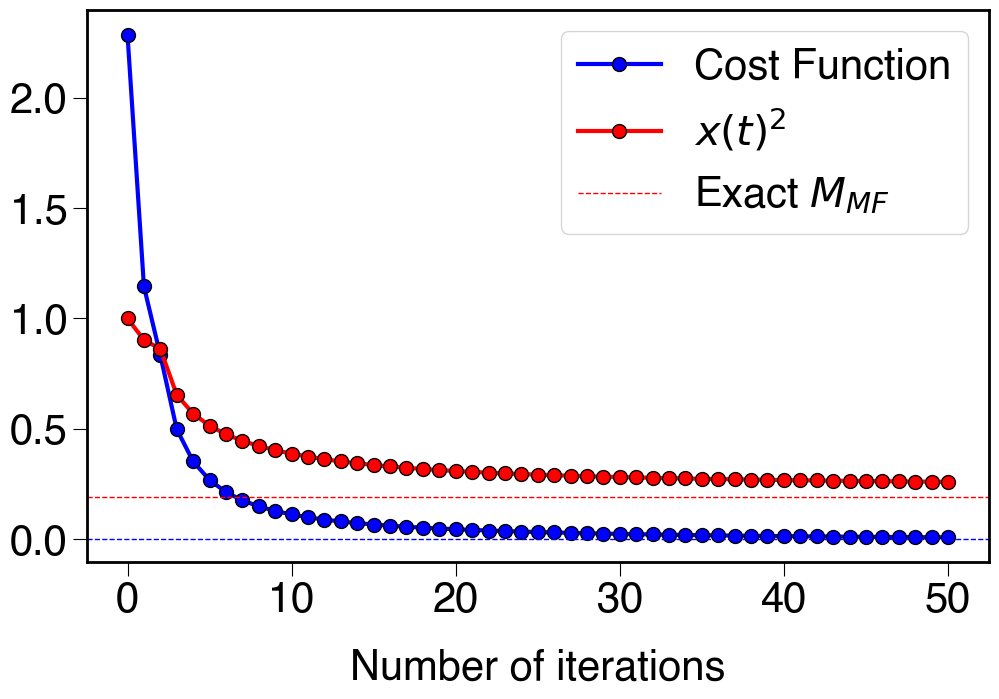

In [40]:
# Plotting the cost function vs iterations with publication-quality settings.
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(cost_values, marker='o', linestyle='-', color='blue', markersize=10, markerfacecolor='blue', markeredgecolor='black', linewidth=3, label='Cost Function')
print('Best cost: ', cost_values[-1])
ax.plot(np.array(x_values)**2, marker='o', linestyle='-', color='red', markersize=10, markerfacecolor='red', markeredgecolor='black', linewidth=3, label=r'$x(t)^{2}$')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=x_steady_state**2, color='red', linestyle='--', linewidth=1, label=r'Exact $M_{MF}$')
ax.set_xlabel('Number of iterations', labelpad=20)
#ax.set_ylabel('Cost', labelpad=20)
ax.legend()
plt.tight_layout()
for spine in ax.spines.values():
     spine.set_linewidth(2)
ax.tick_params(axis='both', which='major', length=10)
# path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/'
# os.chdir(path)
# plt.savefig('cost_function_vs_iterations.png', dpi=600, bbox_inches='tight')
plt.show()

# Density matrix components at each iterations

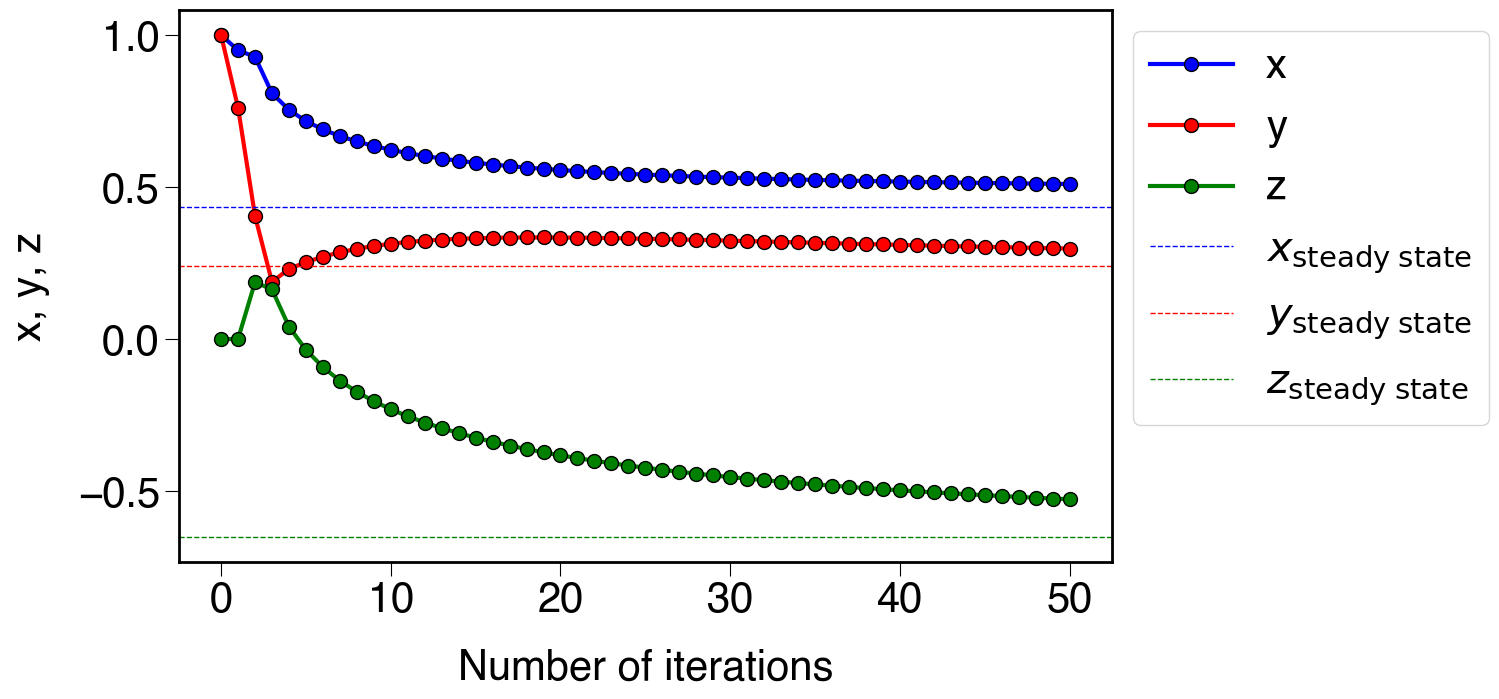

In [16]:
x_lst = []
y_lst = []
z_lst = []
for rho in rho_values:
     x_lst.append(np.real((sigma_x @ unvectorize_rho(rho)).diagonal().sum()))
     y_lst.append(np.real((sigma_y @ unvectorize_rho(rho)).diagonal().sum()))
     z_lst.append(np.real((sigma_z @ unvectorize_rho(rho)).diagonal().sum()))

# Plotting the x, y, z values over iterations with publication-quality settings.
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(x_lst, marker='o', linestyle='-', color='blue', markersize=10, markerfacecolor='blue', markeredgecolor='black', linewidth=3, label='x')
ax.plot(y_lst, marker='o', linestyle='-', color='red', markersize=10, markerfacecolor='red', markeredgecolor='black', linewidth=3, label='y')
ax.plot(z_lst, marker='o', linestyle='-', color='green', markersize=10, markerfacecolor='green', markeredgecolor='black', linewidth=3, label='z')

plt.axhline(y=x_steady_state, color='blue', linestyle='--', linewidth=1, label=r'$x_{\mathrm{steady\; state}}$')
plt.axhline(y=y_steady_state, color='red', linestyle='--', linewidth=1, label=r'$y_{\mathrm{steady\; state}}$')
plt.axhline(y=z_steady_state, color='green', linestyle='--', linewidth=1, label=r'$z_{\mathrm{steady\; state}}$')
ax.set_xlabel('Number of iterations', labelpad=20)
ax.set_ylabel('x, y, z', labelpad=20)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
for spine in ax.spines.values():
     spine.set_linewidth(2)
ax.tick_params(axis='both', which='major', length=10)
# path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/'
# os.chdir(path)
# plt.savefig('x_y_z_vs_iterations.png', dpi=600, bbox_inches='tight')
plt.show()

# Cost function landscape

In [17]:
# # Define angle ranges
# theta1_range = np.linspace(-np.pi, np.pi, 5)
# theta2_range = np.linspace(-np.pi, np.pi, 5)
# theta3_range = np.linspace(-np.pi, np.pi, 5)
# theta4_range = np.linspace(-np.pi, np.pi, 5)

# cost_landscape = np.zeros((len(theta1_range), len(theta2_range), len(theta3_range), len(theta4_range)))

# # Precompute x_initial
# x_initial = np.real((sigma_x @ unvectorize_rho(rho_i)).diagonal().sum())

# # Fill the 4D cost landscape
# for i, t1 in enumerate(theta1_range):
#     for j, t2 in enumerate(theta2_range):
#         for k, t3 in enumerate(theta3_range):
#             for l, t4 in enumerate(theta4_range):
#                 angles_lst = [[t1, t2, t3, t4]]
#                 rho_out = variational_ansatz(1, angles_lst, x_initial, rho_i)
#                 cost = cost_function(unvectorize_rho(rho_out), x_initial, J, L, Delta, gamma_r, gamma_d)
#                 cost_landscape[i, j, k, l] = cost

In [18]:
# # Get index of closest values to π
# theta3_fixed_idx = np.argmin(np.abs(theta3_range - np.pi))
# theta4_fixed_idx = np.argmin(np.abs(theta4_range - np.pi))

# # Extract 2D slice for fixed θ₃ and θ₄
# cost_slice = cost_landscape[:, :, theta3_fixed_idx, theta4_fixed_idx]

# # Create meshgrid for plotting
# T1, T2 = np.meshgrid(theta1_range, theta2_range, indexing='ij')

# # Plotting
# fig = plt.figure(figsize=(12, 8))
# ax_3d = fig.add_subplot(111, projection='3d')
# surf = ax_3d.plot_surface(T1, T2, cost_slice, cmap='viridis', edgecolor='none')

# # Customize labels and colorbar
# cbar = fig.colorbar(surf, ax=ax_3d, shrink=0.5, aspect=10)
# cbar.set_label('Cost Function', labelpad=20)
# ax_3d.set_xlabel(r'$\theta_1$', labelpad=20)
# ax_3d.set_ylabel(r'$\theta_2$', labelpad=20)
# ax_3d.set_zlabel('Cost', labelpad=20)
# ax_3d.view_init(elev=30, azim=45)
# plt.tight_layout()
# plt.title(r'Cost landscape for fixed $\theta_3 = \pi$, $\theta_4 = \pi$')
# plt.show()

## Cluster data plot

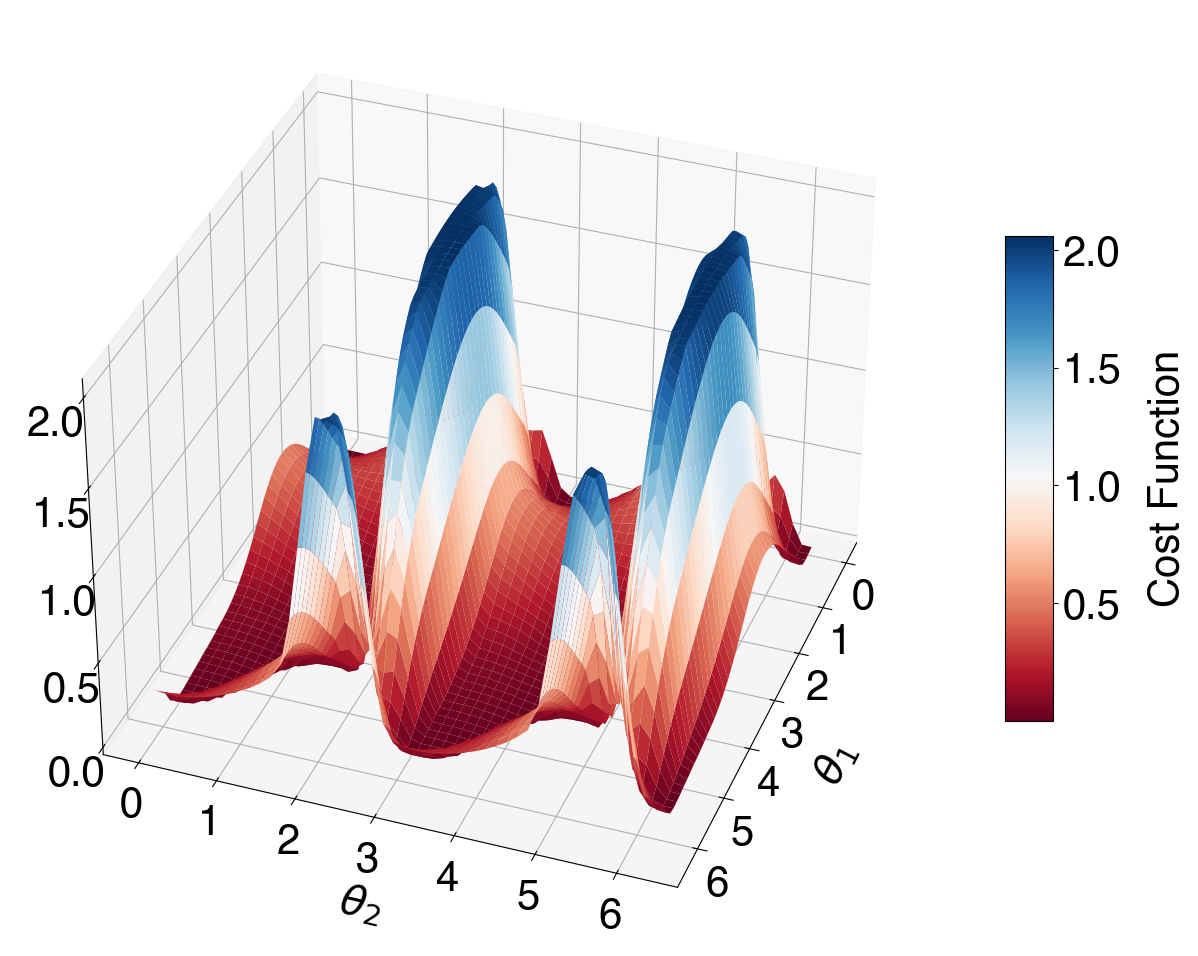

In [19]:
folder_name = 'VQA_cost_function'
path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/'
os.chdir(path)

b = 1
os.chdir(path + folder_name + '/b' + str(b) + '/')
cost_function_values = np.load('cost_landscape.npy')

theta1_range = np.linspace(0, 2*np.pi, 50)
theta2_range = np.linspace(0, 2*np.pi, 50)
theta3_range = np.linspace(0, 2*np.pi, 50)
theta4_range = np.linspace(0, 2*np.pi, 50)

# Create a 3D surface plot
T1, T2 = np.meshgrid(theta1_range, theta2_range)

fig = plt.figure(figsize=(12, 10))
ax_3d = fig.add_subplot(111, projection='3d')
surf = ax_3d.plot_surface(T1, T2, cost_function_values, cmap='RdBu', edgecolor='none')
cbar = fig.colorbar(surf, ax=ax_3d, shrink=0.5, aspect=10)
cbar.set_label('Cost Function', labelpad=20)
ax_3d.set_xlabel(r'$\theta_1$', fontsize=med, labelpad=20)
ax_3d.set_ylabel(r'$\theta_2$', fontsize=med, labelpad=20)
#ax_3d.set_zlabel('Cost', fontsize=med, labelpad=20)
ax_3d.view_init(elev=35, azim=20)  # Adjust elevation and azimuth as needed
plt.tight_layout()
plt.show()

# Stability

In [20]:
# Define parameter values
Delta = 0.6
gamma_r = 0.5
gamma_d = 0.5
JL = 1

# Derived quantities
gamma = gamma_r + gamma_d
numerator = 16 * Delta**2 + gamma**2
denominator = 16 * JL * Delta
sqrt_term = 1 - numerator / denominator

# Check if the fixed point is real
if sqrt_term < 0:
    print("Fixed point is complex. No real solution.")
else:
    common_factor = (gamma_r * gamma) / (8 * JL * Delta)
    y = np.sqrt(common_factor * sqrt_term)
    x = (4 * Delta / gamma) * y
    z = (-16 * Delta**2 - gamma**2) / (16 * JL * Delta)

    # Construct Jacobian matrix numerically
    J = np.array([
        [-gamma / 2, 2 * Delta, 0],
        [-2 * z * JL - 2 * Delta, -gamma / 2, -2 * JL * x],
        [2 * JL * y, 2 * JL * x, -gamma_r]
    ])

    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(J)

    print("Jacobian matrix:")
    print(J)
    print("\nEigenvalues:")
    print(eigenvalues)

    # Stability check
    if np.all(np.real(eigenvalues) < 0):
        print("The fixed point is STABLE.")
    else:
        print("The fixed point is UNSTABLE.")

Jacobian matrix:
[[-0.5         1.2         0.        ]
 [ 0.20833333 -0.5        -0.84261498]
 [ 0.35108957  0.84261498 -0.5       ]]

Eigenvalues:
[-1.  +0.j         -0.25+0.80467385j -0.25-0.80467385j]
The fixed point is STABLE.


In [21]:
# # Fixed JL
# JL = 1.0

# # Ranges for gamma and Delta
# gamma_vals = np.linspace(0.01, 1.6, 500)
# Delta_vals = np.linspace(0.01, 1.5, 500)
# Gamma_grid, Delta_grid = np.meshgrid(gamma_vals, Delta_vals)

# # Initialize phase matrix: 1 = stable, 0 = unstable
# phase = np.zeros_like(Gamma_grid)

# # Loop over grid
# for i in range(Gamma_grid.shape[0]):
#     for j in range(Gamma_grid.shape[1]):
#         gamma = Gamma_grid[i, j]
#         Delta = Delta_grid[i, j]

#         gamma_r = gamma
#         gamma_d = gamma
#         gamma_total = gamma_r + gamma_d  # = 2*gamma

#         denom = 16 * JL * Delta
#         sqrt_term = 1 - (16 * Delta**2 + gamma_total**2) / denom

#         if sqrt_term < 0:
#             continue  # Skip non-physical solutions

#         try:
#             common_factor = (gamma_r * gamma_total) / (8 * JL * Delta)
#             y = np.sqrt(common_factor * sqrt_term)
#             x = (4 * Delta / gamma_total) * y
#             z = (-16 * Delta**2 - gamma_total**2) / denom

#             # Jacobian matrix
#             J = np.array([
#                 [-gamma_total / 2, 2 * Delta, 0],
#                 [-2 * z * JL - 2 * Delta, -gamma_total / 2, -2 * JL * x],
#                 [2 * JL * y, 2 * JL * x, -gamma_r]
#             ])

#             eigs = np.linalg.eigvals(J)
#             if np.all(np.real(eigs) < 0):
#                 phase[i, j] = 1  # Stable

#         except:
#             continue  # Skip numerical issues

# # Plotting
# contour_values = Gamma_grid - 2 * np.sqrt(Delta_grid * (1 - Delta_grid))
# plt.figure(figsize=(10, 7))
# plt.contourf(Delta_grid, Gamma_grid,  phase, levels=[-0.1, 0.5, 1.1], colors=['crimson', 'gold'])
# plt.xlabel(r'$\Delta$', labelpad=20)
# plt.ylabel(r'$\gamma$', labelpad=20)
# plt.tight_layout()
# plt.text(0.5, 1.2, 'Unstable', color='black', fontsize=large, ha='center', va='center')
# plt.text(0.5, 0.4, 'Stable', color='black', fontsize=large, ha='center', va='center')
# plt.contour(
#     Delta_grid, Gamma_grid, contour_values, 
#     levels=[0], colors='white', linestyles='dashed', linewidths=2, label = 'Phase boundary'
# )
# path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/'
# os.chdir(path)
# plt.savefig('stability_phase_diagram.pdf', dpi=600, bbox_inches='tight')
# plt.show()